$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
$$

# CS236781: Deep Learning
# Tutorial 5: Optimization

## Introduction

In this tutorial, we will cover:  **TODO**

- Backpropagation
- Optimization
- Automatic differentiation
- PyTorch backward functions
- Bi-level differentiable optimization

In [1]:
# Setup
%matplotlib inline
import os
import sys
import time
import torch
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory Reminders

### Descent-based optimization

As we have seen, training deep neural network is performed iteratively using descent-based optimization.

The general scheme is,

1. Initialize parameters to some $\vec{\Theta}^0 \in \set{R}^P$, and set $k\leftarrow 0$.
2. While not converged:
    1. Choose a direction $\vec{d}^k\in\set{R}^P$
    2. Choose a step size $\eta_k\in\set{R}$
    3. Update: $\vec{\Theta}^{k+1} \leftarrow \vec{\Theta}^k + \eta_k \vec{d}^k$
    4. $k\leftarrow k+1$


Which descent direction to choose?

The one which maximally decreases the loss function $L(\vec{\Theta})$:

$$
\vec{d} =\arg\min_{\vec{d'}} L(\vec{\Theta}+\vec{d'})-L(\vec{\Theta})
\approx
\arg\min_{\vec{d'}}\nabla L(\vec{\Theta})^\top\vec{d'}, \
\mathrm{s.t.} \norm{\vec{d}}_p=1
$$

Choice of norm determines $\vec{d}$. For example,
- $p=1$: Coordinate descent: direction of the largest gradient component.
- $p=2$: Gradient descent: $\vec{d}=-\nabla L(\vec{\Theta})$.

|$p=1$|$p=2$|
|---|---|
|<img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Coordinate_descent.svg" width="300" /> | <img src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Gradient_descent.svg" width="300" />| 

#### Drawbacks and mitigations?

**Susceptible to initialization**

Initializing near local minima can prevent finding better ones.

<center><img src="imgs/sgd-init.png" width="600" /></center>

Can use stochastic gradient to get a different loss surface every iteration.


<center><img src="imgs/sgd-loss.png" width="500" /></center>

**Sensitive to learning rate**

<center><img src="imgs/sgd-lr.png" width="800"/></center>

- Line search (1D minimization):
$$
\eta_k = \arg\min_{\eta'} L(\vec{\Theta}^k+\eta'\vec{d}^k)
$$

- Adaptive LR optimizers, e.g. Adam

- LR scheduling
<center><img src="imgs/sgd-lr-schedule.png" width="500"/></center>

**Zig-zags in narrow "ravines"**

<center><img src="imgs/sgd-zigzag.png" width="300"/></center>

- Momentum: Use previous gradients to build "speed" in the common direction and cancel-out oscillations in opposite directions.

- BatchNorm: Normalizes activations to zero-mean and unit variance (reduces curvature)

- Second-order methods: Use quadratic local approximation of the loss surface, instead of linear.
    - Newton's method: $\vec{d}_k=\mat{H}_k^{-1}\vec{g}_k = \nabla^2 L(\vec{\Theta}_k)^{-1}\nabla L(\vec{\Theta}_k)$.
    - Quasi-Newton methods which use some estimate of the Hessian based on first-order information (e.g. BFGS).

### The back-propagation algorithm

All the above optimization methods have a crucial thing in common: They require calculation of gradients of the loss w.r.t. to the parameters.

In practical settings when training neural networks we have many different parameters tensors we would like to update separately. Thus, we require the gradient of the loss w.r.t. each of them.

Back-propagation is an efficient way to calculate these gradients using the chain rule.

We represent the application of a model as a **computation graph**.
For example, a simple linear regression model can be represented as:

<center><img src="imgs/backprop-graph.png" width="350"/></center>

Imagine that in this graph we have $N$ variables $\vec{v}^i,\ 1\leq i \leq N$  and functions $f_i$ which compute them from other variables.

The graph is directional, thus assume $\vec{v}^1, \vec{v}^2,\dots,\vec{v}^N$ represents a topological order of the graph (parents before children).

Define also the notation $\delta\vec{v}\triangleq \pderiv{L}{\vec{v}}$.

The forward pass can therefore we written as:

1. For $i=1,2,\dots,N$:
  1. Graph parents of current node: $$\mathcal{P}_i \leftarrow \left\{\vec{v}^j ~\middle\vert~ \vec{v}^j \text{ parent of } \vec{v}^i\right\}$$ 
  2. Evaluate function at current node: $$\vec{v}^i\leftarrow f_i(\mathcal{P}_i)$$

And in the backward pass we traverse the graph in reverse and apply the chain rule:

1. Set $\delta\vec{v}^N=1$.
2. For $i=N,N-1,\dots,1$:
  1. Graph children of current node: $$\mathcal{C}_i \leftarrow \left\{\vec{v}^j ~\middle\vert~ \vec{v}^j \text{ child of } \vec{v}^i\right\}$$  
  2. Chain rule: $$\delta\vec{v}^i\leftarrow \sum_{\vec{v}^j\in\mathcal{C}_i} \delta\vec{v}^j\pderiv{\vec{v}^j}{\vec{v}^i}$$
  
Notes:
1. The expression $\delta\vec{v}^j\pderiv{\vec{v}^j}{\vec{v}^i}$ is a "vector"-Jacobian product (VJP).
2. When a computation node's output is used by more than one other node (more than one child in the graph), we sum the incoming gradients from these children. This again arises directly from the chain rule.

Backpropagation easily lends itself to a modular and efficient implementation.


Modularity:
- Nodes in the computation graph only need to know how to calculate their own derivatives.
- This is then passed to the parent nodes, which can do the same.


<center><img src="imgs/backprop-modular.png" width="500"/></center>

Efficiency:

- Only need to compute each $\delta\vec{v}^i$ once.
- No need to construct the Jacobian, instead calculate the VJP directly since that's what we actually need.

Modern automatic-differentiation packages such as PyTorch's `autograd` utilize exactly these tricks to implement backprop in an extremely powerful way.

## Part 1: Custom automatic differentiation with PyTorch

We'll now learn how to extend PyTorch's `autograd` by defining our own custom nodes in the computation graph.

Lets first introduce a cousin of ReLU, the Exponential-Linear Unit (ELU) activation function:

$$
f(z) =
\begin{cases}
z, & z > 0\\
\alpha \left(e^{z}-1\right) & z \leq 0
\end{cases}
$$

We'll pretend PyTorch does not include this activation function and implement a custom version ourselves.

In [3]:
import torch
import torch.autograd as autograd
import torchviz

from torch import Tensor

First, we'll implement just the actual computation as a standalone function so that we can reuse it later.

In [4]:
def elu_forward(z: Tensor, alpha: float):
    elu_positive = z
    elu_negative = alpha * (torch.exp(z) - 1)
    elu_output = torch.where(z>0, elu_positive, elu_negative)
    return elu_output

A quick visualization to see what it looks like:

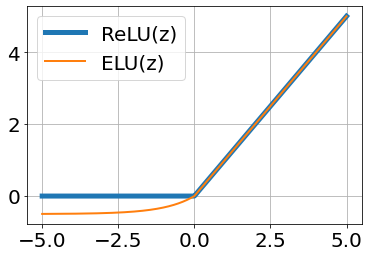

In [5]:
z = torch.linspace(-5, 5, steps=1000)
plt.plot(z.numpy(), torch.relu(z).numpy(), label='ReLU(z)', linewidth=5);
plt.plot(z.numpy(), elu_forward(z, alpha=0.5).numpy(), label='ELU(z)', linewidth=2); plt.legend(); plt.grid();

Now we'll wrap it as an `nn.Module` so that we can use it as a layer in a model.

In [6]:
class ELU(torch.nn.Module):
    """ ELU Activation layer """
    
    def __init__(self, alpha: float = 0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, z: Tensor):
        return elu_forward(z, self.alpha)
    

And as usual, we can look at the resulting computation graph.

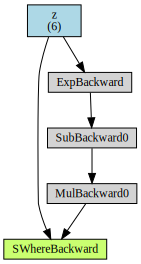

In [7]:
elu = ELU(alpha=0.5)
z = torch.tensor([-2., -1, 0, 1, 2, 3], requires_grad=True)
torchviz.make_dot(elu(z), params=dict(z=z))

We can see that the computation graph accurately represents the various basic mathematical operations performed bby our `elu_forward` function.

But what if we want to define the entire ELU operarion as one node in the graph?
This can be useful e.g. for performance reasons.

But how can we accomplish this?

The solution is to use a lower-level PyTorch API, `autograd.Function`
which allows us to define a function in terms of both it's forwards pass
(the regular output computation), and it's **backward** pass
(the gradient w.r.t. all it's inputs).


From the PyTorch docs:
    
    Every operation performed on Tensor s creates a new Function object, that performs the computation, and records that it happened. The history is retained in the form of a DAG of functions, with edges denoting data dependencies (input <- output). Then, when backward is called, the graph is processed in the topological ordering, by calling backward() methods of each Function object, and passing returned gradients on to next Function s.



We'll first calculate the simple analytic derivative of the ELU function:
$$
\pderiv{f(z)}{z} = f'(z) = 
\begin{cases}
1, & z > 0\\
\alpha e^{z} & z \leq 0
\end{cases}
$$

Next, we need to figure out how to compute the vector-Jacobian product efficiently.
Note that for any **elementwise** operation, $\vec{y}=f(\vec{x}),\ f:\set{R}^n\rightarrow\set{R}^n$, we can write the Jacobian as

$$
\pderiv{\vec{y}}{\vec{x}} = \pmatrix{
\ddots & \vdots & \\
\cdots & \pderiv{y_i}{x_j} & \cdots \\
& \vdots & \ddots\\
}
=
\pmatrix{
f'(x_1) &  &  \\
  & f'(x_i) &  \\
& & f'(x_n)\\
}
= \diag\{{f'(\vec{x})}\}
$$

And it follows that the VJP can be computed simply:
$$
\delta \vec{x} = \delta{\vec{y}}\pderiv{\vec{y}}{\vec{x}} = \delta{\vec{y}} \odot f'(\vec{x}).
$$

Now, equipped with the expression for the VJP, we can proceed to implement the Function object representing ELU.

In [8]:
class ELUFunction(autograd.Function):
    
    @staticmethod
    def forward(ctx, z: Tensor, alpha: float):
        elu = elu_forward(z, alpha) # Regular forward pass computation from before
        ctx.save_for_backward(z)    # Tensors should be saved using this method
        ctx.alpha = alpha           # other properties can bbe saved like so
        return elu
    
    @staticmethod
    def backward(ctx, grad_output):
        z, = ctx.saved_tensors
        alpha = ctx.alpha
        
        # Calculate diagonal of d(elu(z))/dz
        grad_positive = torch.ones_like(z)
        grad_negative = alpha * torch.exp(z)
        
        # Note: This is not the full Jacobian
        grad_elu = torch.where(z>0, grad_positive, grad_negative)
        
        # Gradient of the loss w.r.t. our output
        δ_elu = grad_output
        
        # Calcualte δz = d(elu(z))/dz * δ_elu
        # Note: elementwise multiplication equivalant to vector-Jacobian product
        print(f'{grad_elu.shape=}, {δ_elu.shape=}')
        δz = grad_elu * δ_elu
        return δz, None

We can now use this custom `Function` either directly or as part of a layer.

For example, here's an ELU layer using our custom backward:

In [9]:
class ELUCustom(torch.nn.Module):
    """ ELU Layer with a custom backward pass """
    
    def __init__(self, alpha: float = 0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, z: Tensor):
        # Function.apply() invokes the forward pass
        return ELUFunction.apply(z, self.alpha)

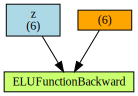

In [10]:
elu_custom = ELUCustom(alpha=0.5)
z = torch.tensor([-2., -1, 0, 1, 2, 3], requires_grad=True)
torchviz.make_dot(elu_custom(z), params=dict(z=z),)

This only tested the forward pass. Let's now put our custom layer in the context of a larger model and see that we can backprop through it.

In [11]:
elu_mlp = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=1024),
    ELUCustom(alpha=0.01),
    torch.nn.Linear(in_features=1024, out_features=1024),
    ELUCustom(alpha=0.01),
    torch.nn.Linear(in_features=1024, out_features=10),
    torch.nn.Softmax(dim=1)
)

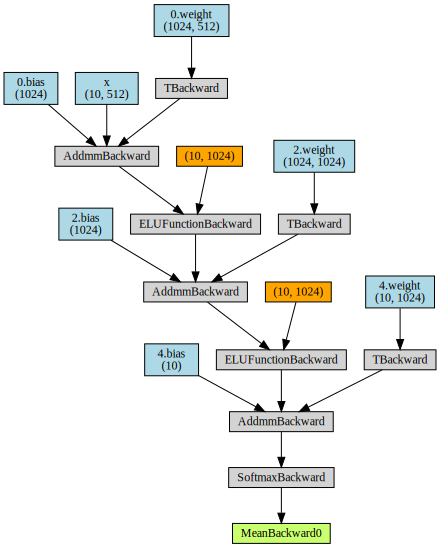

In [12]:
x = torch.randn(10, 512, requires_grad=True)
torchviz.make_dot(elu_mlp(x).mean(), params=dict(list(elu_mlp.named_parameters()) + [('x', x)]))

Let's run the backward pass and make sure we have gradients on all parameter tensors.

In [13]:
l = torch.sum(elu_mlp(x))
l.backward()

for name, param in elu_mlp.named_parameters():
    print(f"{name} {torch.norm(param.grad).item()}")

grad_elu.shape=torch.Size([10, 1024]), δ_elu.shape=torch.Size([10, 1024])
grad_elu.shape=torch.Size([10, 1024]), δ_elu.shape=torch.Size([10, 1024])
0.weight 3.8951057490521634e-07
0.bias 1.5102544992373623e-08
2.weight 5.098933115732507e-07
2.bias 3.209331467246557e-08
4.weight 4.6191954083951714e-07
4.bias 5.746612075085977e-08


## Part 2: Differentiable Optimization

Now we'll tackle a more interesting use-case for defining our custom backward functions: differentiating though an inner optimization problem.

What if we want to solve an inner optimization problem as part of our model, while the parameters of the inner problem are also optimized by the end-to-end optimization of the entire model?

<center><img src="imgs/bilevel.png" width="600"/></center>

Training such a network end-to-end means we're trying to find:

$$
\begin{align}
\vec{\Theta}^\ast
&=
\arg\min_{\vec{\Theta}} \E[(\vec{x},\vec{y})\sim D]{\mathcal{L}(\vec{y}, \hat{\vec{y}})}\\
&=
\arg\min_{\vec{\Theta}} \E[(\vec{x},\vec{y})\sim D]{
\mathcal{L}(\vec{y}, \arg\min_{\vec{y}} f(\vec{y}, h_{\vec{\Theta}}(\vec{x}) )
}
\end{align}
$$

This type of setting is also known as a bi-level optimization problem.

From the perspective of the inner problem, $\vec{z}$ is a "fixed" parameter. 

However, from the perspective of end-to-end training, we're optimizing $\vec{\Theta}$ in order to reduce the final loss.

Therefore, we can view this as learning to parameterize the inner task.

What do we need in order to train such a model end-to-end?

As usual, we must find a way to calculate a VJP, in this case:
$$
\delta \vec{z} = \pderiv{\hat{\vec{y}}}{\vec{z}}\ \delta\hat{\vec{y}}.
$$

Assume that $\vec{y}=\arg\min_{\vec{y}'}f(\vec{y}', \vec{z})$.

Since $\vec{y}$ is a minimizer of the function $f$, the necessary optimality condition
must hold: $$\nabla_{y}f(y, z)=0.$$

If we then perturb $\vec{z}$ by $d\vec{z}$, we'll get a slightly different minimizer, $\vec{y}+d\vec{y}$. Thus also,

$$\nabla_{y}f(y+dy, z+dz)=0.$$

We can take a first-order Taylor expansion of $\nabla_{y}f$ around the point $(y, z)$:

$$
\nabla_{y}f(y+dy, z+dz) \approx \nabla_{y}f(y, z) + \nabla^{2}_{yy}f(y,z)dy + \nabla^{2}_{yz}f(y, z)dz = 0.
$$

Since $\nabla_{y}f(y, z)=0$, we rearrange to obtain:

$$
\nabla^{2}_{yy}f(y,z)dy = -\nabla^{2}_{yz}f(y, z)dz.
$$

We'll denote the Hessians as $\mat{K}=\nabla^{2}_{yy}f(y,z)$ and $\mat{R}=\nabla^{2}_{yz}f(y, z)$. We then obtain,

$$
\mat{K}d\vec{y}=-\mat{R}d\vec{z}\Longrightarrow d\vec{y}=-\mat{K}^{-1}\mat{R}d\vec{z}.
$$

The above equation means that we have found a linear relationship between the change in the function value, $d\vec{y}$ and the change in the argument value, $d\vec{z}$.
This linear relationship must be, by definition, related to the gradient of $\vec{y}$ w.r.t. $\vec{z}$.

Writing the above as an inner product, we have $$d\vec{y}=\ip{\mattr{R}\mat{K^{-T}}}{d\vec{z}}{}.$$

Note that $\mat{K}$ is a Hessian, therefore symmetric and we can drop the transpose.

Finally, by the "outer" definition of the gradient we see that $$\pderiv{\vec{y}}{\vec{z}}=\mattr{R}\mat{K^{-1}}.$$

Now back to our VJP: we need 
$$
\delta \vec{z} =  \pderiv{\vec{y}}{\vec{z}} \delta\vec{y} =\mattr{R}\mat{K^{-1}}\delta\vec{y}.
$$

We'll do the calculation in two steps:
1. Calculate $\delta\vec{u}=\mat{K}^{-1}\delta\vec{y}$: Equivalent to solving the linear system $\mat{K}\delta\vec{u}=\delta\vec{y}$.
2. Calculate $\delta\vec{z} = -\mat{R}^\top \delta\vec{u}$.

Finally, based on this, we have a way to implement such an inner-optimization layer:

**Forward pass**: Compute the optimal solution of the inner problem, either with a some solver or even a closed-form expression.

**Backward pass**: Calculate $\delta\vec{z}$ using the two-step procedure described above.

In [93]:
def solve_ls(A: Tensor, B: Tensor, abs: float = 1e-6, rel: float = 1e-6) -> Tensor:
    """
    Solve least squares fit AX=B using SVD and returns X
    :param abs: Absolute threshold to reject small eigenvalues.
    :param rel: Relative threshold to reject small eigenvalues.
    """
    U, S, V = torch.svd(A)
    th = max(rel * S[0].item(), abs)
    # th = torch.max(rel * S[..., 0], torch.tensor(abs))
    Sinv = torch.where(S >= th, 1.0 / S, torch.zeros_like(S))
    return V @ torch.diag(Sinv) @ (U.transpose(1, 0) @ B)


In [178]:
def flatten(*z: Tensor):
    flat_z = torch.cat([z_.view(-1) for z_ in z], dim=0)
    return flat_z

def unflatten_like(t_flat: Tensor, *z: Tensor):
    t_flat = t_flat.view(-1) # make sure it's 1d
    ts = []
    offset = 0
    for z_ in z:
        numel = z_.numel()
        ts.append(
            t_flat[offset:offset+numel].view_as(z_)
        )
        offset += numel
    assert offset == t_flat.numel()
    
    return tuple(ts)

In [179]:
t1, t2 = torch.randn(3, 5), torch.randn(2, 4)
t_flat = flatten(t1, t2)
t_flat

tensor([ 0.1314, -0.0325,  0.7559,  0.5041, -2.4287, -0.5212, -1.2013,  0.9900,
         0.9652,  0.1030,  1.4274,  0.1940, -1.1418,  0.3150, -0.3024,  0.4177,
         2.0186, -0.8440,  0.3654, -0.0769,  0.3944, -2.9447, -0.4860])

In [180]:
t1_, t2_ = unflatten_like(t_flat, t1, t2)
assert torch.allclose(t1, t1_)
assert torch.allclose(t2, t2_)

In [181]:
from torch.optim import LBFGS

def argmin_forward(ctx, obj_fun, y, *z):
    
    optimizer = LBFGS(params=(y,), lr=0.1, max_iter=1000)

    # Solve the optimization problem
    def _optimizer_step():
        # zero gradients
        y.grad = torch.zeros_like(y)
        # evaluate loss
        f = obj_fun(y, *z)
        # calculate gradients
        # Note: not calling backward() because we don't want to compute
        # gradients for anything except y
        δy = autograd.grad(f, (y,), create_graph=False,)[0]
        y.grad += δy
        return f

    f_min = optimizer.step(_optimizer_step,)
    y_argmin = y # optimized in place

    ctx.save_for_backward(y_argmin, *z)
    ctx.obj_fun = obj_fun

    return y_argmin

In [182]:
from torch.autograd.functional import hessian

def argmin_backward(ctx, grad_output):
    y_argmin, *z = ctx.saved_tensors
    obj_fun = ctx.obj_fun

    print(f'*** Argmin Backward ***')

    # Hessians
    flat_y = flatten(y_argmin)
    flat_z = flatten(*z)
    print(f'*** {flat_z.shape=}')
    
    def obj_fun_flat(flat_y, flat_z):
        # Wrap objective so that we can call it with flat tensors
        y = unflatten_like(flat_y, y_argmin)
        zs = unflatten_like(flat_z, *z)
        return obj_fun(*y, *zs)
    
    H = hessian(obj_fun_flat, inputs=(flat_y, flat_z), create_graph=False)
    Hyy = K = H[0][0]
    Hyz = R = H[0][1]
    print(f'{K.shape=}, {R.shape=}')

    # Now we need to calculate δz = -R^T K^-1 δy
    # 1. Solve system for δu: K δu = δy
    δy = grad_output
    print(f'{δy.shape=}') 

    δy = torch.reshape(δy, (-1, 1))
    δu = solve_ls(K, δy) # solve_ls(A, B) solves A X = B
    print(f'{δu.shape=}') 

    # 2. Calculate δz = -R^T δu
    δz_flat = -R.transpose(0, 1) @ δu
    print(f'{δz_flat.shape=}') 
    
    # Extract gradient of each individual z
    # δz = torch.reshape(δz, z.shape)
    print(f'***\n{δz_flat=}')
    print(f'***\n{δz_flat.shape=}')
    print(f'***\n{z=}')
    δz = unflatten_like(δz_flat, *z)
    print(f'***')

    δy = torch.reshape(δy, y_argmin.shape)
    print(f'###')

    return None, δy, *δz

In [183]:
class ArgMinFunction(autograd.Function):
    @staticmethod
    def forward(ctx, obj_fun, y, *z):
        return argmin_forward(ctx, obj_fun, y, *z)
    
    @staticmethod
    def backward(ctx, grad_output):
        return argmin_backward(ctx, grad_output)

In [184]:
torch.set_default_dtype(torch.float64)

In [185]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

N, D = 100, 10

X, y, w_gt = make_regression(
    n_samples=N, n_features=D, coef=True, random_state=42, bias=10, noise=1,
)

X, y, w_gt = [ torch.from_numpy(t).to(torch.float64) for t in [X, y, w_gt] ]

print(f"{X.shape=}, {y.shape=}, {w_gt.shape=}")

X.shape=torch.Size([100, 10]), y.shape=torch.Size([100]), w_gt.shape=torch.Size([10])


In [186]:

def obj_fun(w: Tensor, l1: Tensor, l2: Tensor):
    loss = torch.mean((X @ w - y)**2)
    reg1 = l1 * torch.mean(torch.abs(w))
    reg2 = l2 * torch.mean(w ** 2)
    return torch.sum(loss + reg1 + reg2)

obj_fun(
    w=torch.randn_like(w_gt, requires_grad=True),
    l1=torch.randn(1, 1, requires_grad=True),
    l2=torch.randn(1, 1, requires_grad=True),
)

tensor(36505.2324, grad_fn=<SumBackward0>)

In [193]:
w=torch.randn_like(w_gt, requires_grad=True)
l1=torch.randn(1, requires_grad=True)
l2=torch.randn(1, requires_grad=True)
print(f'{torch.norm(w_gt-w)=}')

w_argmin = ArgMinFunction.apply(obj_fun, w, l1, l2)
w_argmin

torch.norm(w_gt-w)=tensor(184.5435, grad_fn=<NormBackward0>)


tensor([16.9955, 50.8658,  3.4545, 58.4062, 84.4079, 68.8225, 80.5330,  5.9484,
         5.0106, 63.7150], grad_fn=<ArgMinFunctionBackward>)

In [194]:
torch.norm(w_gt-w)

tensor(15.7462, grad_fn=<NormBackward0>)

In [195]:
l = torch.sum(w_argmin)
l

tensor(438.1594, grad_fn=<SumBackward0>)

In [196]:
print(f'{w.grad=}')
print(f'{l1.grad=}')
print(f'{l2.grad=}')

w.grad=tensor([-1.8944e-05, -3.6243e-05, -6.1208e-06, -4.4747e-05, -5.1763e-05,
        -6.5553e-05, -6.8470e-05,  2.3221e-05, -1.2681e-05, -4.4842e-05])
l1.grad=None
l2.grad=None


In [197]:
l.backward()

*** Argmin Backward ***
*** flat_z.shape=torch.Size([2])
K.shape=torch.Size([10, 10]), R.shape=torch.Size([10, 2])
δy.shape=torch.Size([10])
δu.shape=torch.Size([10, 1])
δz_flat.shape=torch.Size([2, 1])
***
δz_flat=tensor([[0.],
        [0.]])
***
δz_flat.shape=torch.Size([2, 1])
***
z=[tensor([-1.3187], requires_grad=True), tensor([0.8362], requires_grad=True)]
***
###


In [198]:
print(f'{w.grad=}')
print(f'{l1.grad=}')
print(f'{l2.grad=}')

w.grad=tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000,
        1.0000])
l1.grad=tensor([0.])
l2.grad=tensor([0.])


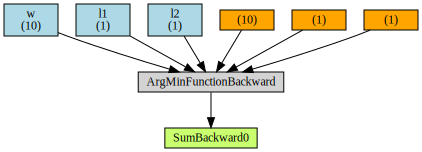

In [201]:
torchviz.make_dot(torch.sum(ArgMinFunction.apply(obj_fun, w, l1, l2)), params={'w':w,'l1':l1,'l2':l2})

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Dr. Roger Grosse, UToronto, cs321
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017
